In [3]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, beta, binomial, randint
from scipy.stats import norm

# Gibbs Sampling for Markov Switching Model

By: Yash Permalla and Virochan Pandit

Hidden Markov models (HMMs) are a widespread framework for observation settings, where an underlying Markov chain $s_t$ progresses based on a transition matrix or kernel $P$, and these states are only observed through observations $z_t = f(s_t)$. We investigate a similar model, known as a Markov switching model. Switching models use a discrete state space for the hidden Markov chain, and are often applied in time series settings, where observations are a function of both the current hidden state and past observations, and the observations themselves are of interest. The hidden states correspond to regime changes that affect volatility and patterns in updates to existing observations, such as in financial markets and natural phenomena. We present an implemention of Gibbs sampling to estimate $s_{1:T}, P, f$ based only on observed data $z_{1:T}$.

Consider a generalized two state switching model. When $s_t = 0$ the data is described by $\mu_0$ and autoregressive components and when $s_t = 1$ the data is described by $\mu_1$ and another set of autoregressive components. This is the general setting for two state switching model:

$$
z_t = \begin{cases} 
      \mu_0 + \sum_{i=1}^k a_i z_{t-i} + e_t & s_t = 0 \\
      \mu_1 + \sum_{i=1}^k b_i z_{t-i} + e_t & s_t = 1 
   \end{cases},
   \quad e_t \overset{\mathrm{iid}}{\sim} N(0,\sigma^2)
$$

The states themselves change according to a Markov model with the matrix 
$$
P = 
\begin{bmatrix}
p_{00} & p_{10} \\
p_{01} & p_{11} 
\end{bmatrix}
$$

For example $P(s_t = 1 | s_{t-1} = 1) = p_{11}$

The goal is to estimate the paremeter space $\theta = \{s_{1:T}, \mu_0, \mu_1, a_{1:k}, b_{1:k}, p_{00}, p_{11}\}$ (assume $\sigma^2$ known). This can be done through various methods, including EM and Gibbs Sampling.

# Example

Here, we present a simplified model of Markov Switching Model, where we do not consider any autoregressive components. For this simplified setting, we derive relevant posteriors and present the complete Gibbs Sampling Algorithm.

$$
z_t = \begin{cases} 
      u_0 +e_t & s_t =0 \\
      u_1 + e_t & s_t = 1 \\ 
   \end{cases}
    \hspace{15pt} e_t \overset{\mathrm{iid}}{\sim} N(0,\sigma^2) 
$$

Goal: Estimate $\theta = \{s_{1:T}, \mu_0, \mu_1, p_{00}, p_{11}\}$ (assume $\sigma^2$ known)

For example, consider the setting when we have $\mu_1 = 1.4$ and $\mu_2 = 1.6$. Further $p_{00} = p_{11} = 0.9$

In [2]:
#This generates hidden and observed data in our simplified non-autoregressive model with 2 states
def generateData(n=250, mean0 = 1, mean1 = 2, var=0.1, p00=0.9, p11=0.9):
    
    observedstates = np.zeros(n+1)
    hiddenstates = np.zeros(n+1, dtype=int)
    
    hiddenmarkov = np.array([[p00, 1-p00],[1-p11, p11]])

    observedstates[0] = np.random.normal(1, var)

    for i in range(1,n+1):
        curr_state = hiddenstates[i-1]
        hiddenstates[i] = np.random.choice([0, 1], p=hiddenmarkov[curr_state])
        observedstates[i] = np.random.normal(mean1, var) if hiddenstates[i] else np.random.normal(mean0, var)

    return hiddenstates, observedstates

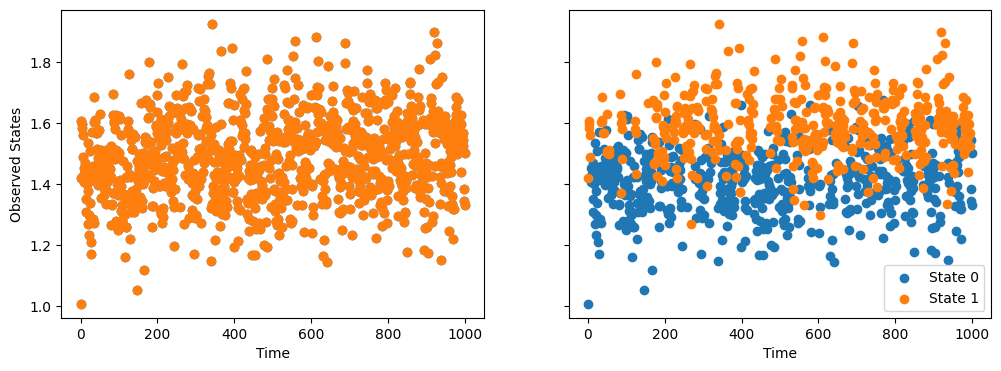

In [5]:
hidden, observed = generateData(1000, mean0=1.4, mean1=1.6)

times = np.arange(len(hidden))


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

for label in np.unique(hidden):
    axs[0].scatter(times, observed)
    axs[1].scatter(times[hidden==label],observed[hidden==label], label=f"State {label}")

axs[0].set_ylabel("Observed States")
axs[0].set_xlabel("Time")
axs[1].set_xlabel("Time")
axs[1].legend()

plt.show()


# Gibbs Sampler

In order to reach our goal and estimate the parameter space, we need to perform Gibbs sampling for parameter estimation. We do so by breaking the joint into a series of conditions and sampling each conditional for every iteration. We formalize this below:

Let $\theta = \left( \{s_{1:T}\}, \{\mu_0, \mu_1\}, \{p_{00}, p_{11}\} \right) $, i.e. the parameter space. Note how we break the parameter space into sets of parameters.

Our overall goal is to sample from $P(\theta | z_{1:T})$. In other words, given the observations we want to estimate the parameters. We use Gibbs sampling to sample from each of the following conditions to approximate the joint distribution. The goal then becomes to find posteriors for the three distributions listed below. Note, we denote $c = \{\mu_0, \mu_1\}$ and $p = \{p_{00}, p_{11}\}$

-  $ {s_{1:T}} \mid c, p, z_{1:T}$      
- $ {c}       \mid s_{1:T}, p, z_{1:T} $
- $ {p}       \mid s_{1:T}, c, z_{1:T} $


Sampling from each of these conditional effectively samples from the joint parameter space by Gibbs Sampling.

# Forward-Backward Algorithm

For the first of these posteriors, namely $ P({s_{1:T}} \mid c, p, z_{1:T})$, we cannot directly compute it, but we instead use the Forward-Filtering Backward-Sampling algorithm.

First we compute filtering probabilities $\alpha_t(k)$. Note that they condition on the observed states up to time $t$

$$
\alpha_t(k) := P(s_t = k | z_{1:t})
$$

We compute this for all timesteps from 1 to $T$

$$
\alpha_1(k) = P(s_t = k | z_1) \propto P(z_1 | s_1 = k) P(s_1 = k) = \pi_k \, \mathcal{N}(\mu_k, \sigma^2)
$$



Here $\pi_k$ is a prior for the distribution of the states. In our case, we assumed that $\pi_k$ was discrete uniform over the stationary distribution of the intial transition matrix.


$$
\alpha_2(k) \propto P(z_2 | s_2 = k) \sum_{j=0}^{1} \alpha_{1}(j) p_{jk}
$$

$$
\vdots
$$

$$
\alpha_T(k) \propto P(z_T | s_T = k) \sum_{j=0}^{1} \alpha_{T-1}(j) p_{jk}
$$

Now, that we have computed all the filtering probabilities we know that for time $T$, we have that $s_T$ is discrete uniform over the normalized filtering probabilities:
\begin{matrix}
[ \alpha_T(1) & \alpha_T(2) & \cdots & \alpha_T(k) ]
\end{matrix}

Then for $T-1$ to $1$ we sample the states by using the following equation. This the backward part of the method.

$$
P(s_t = i | s_{t+1} = j, z_{1:T}) \propto \alpha_t(i) p_{ij}
$$

After all full run of the forward backward algorithm, we have generated $s_1 ... s_T$

# Bayesian Update of Parameters

For the other two parameter sets, we use Bayesian updates. Let us start with the mean update step. We have
$
c = \{ \mu_0 , \mu_1 \}
$
and we want to sample from $P(c | z_{1:T},s_{1:T})$. Below, we show the process of doing so for $\mu_0$

$$\mu_0 \overset{\mathrm{prior}}{\sim} \mathcal{N}(m_0,v_0)$$

Note that $P(\mu_0| z_{1:T})$ only depends on those obserations with hidden state of 0, meaning $P(\mu_0| z_{1:T})= P(\mu_0| \{ z_t : s_t = 0 \} )$. 

We denote $z_0 = \{ z_t : s_t = 0 \}$ and $n_0 = |z_0|$

$$
P(\mu_0 | z_0) \propto P(z_0 | \mu_0) P(\mu_0) = \mathcal{N}(\mu_0; m_0, v_0) \prod_{i=1}^{n_0} \mathcal{N}(z_i; \mu_0, \sigma^2)
$$

After some algebra this simplifies to:

$$\mu_0 \overset{\mathrm{post}}{\sim} 
\mathcal{N}\left(
(\frac{\sum_{i:s_i = 0} z_i}{\sigma^2} + \frac{m_0}{v_0}) \times v^*, v^* \right), v^* = (\frac{n_0}{\sigma^2} + \frac{1}{v_0})^{-1}$$

Finally, we can move to the transition probability update step.

We have
$
p = \{ p_{00} , p{11} \}
$
and we want to sample from $P(p | z_{1:T},s_{1:T})$

The likelihood here is binomial. For instance, for $p_{00}$ we only need to consider observations in which we start at state 0. This is because the likelihood considers that from state 0 how many times does the state transition to state 1 versus stay in state 0.

 $$ n_{ab} := \text{number of transitions from state a to state b}$$



$$ p_{00} \overset{\mathrm{prior}}{\sim} \text{Beta}(\alpha_0, \beta_0) $$

 $$ p_{00} \overset{\mathrm{post}}{\sim} \text{Beta}(\alpha_0 + n_{00}, \beta_0 + n_{01}) $$

A similar update is made for $p_{11}$. We are now ready to set up the Gibbs Sampler and conduct the analysis.

# Gibbs Sampler

In [6]:
#This class handles Gibbs sampling
class GibbsSampler:
    def __init__(self, observed_data, numstates=2, var=0.1, ar=0):
        """
        Args: 
            observed_data (list or np.array): Observations.
            numstates (int): Number of hidden Markov states.
            var (float): Assumed true variance of noise.
            ar (int): Autoregressive order (not implemented)
        """
        self.observed_data = observed_data
        self.numstates = numstates #markov states
        #self.ar = ar     #autoregressive components   
        self.var = var    #noise param

        self.hiddenestimates = np.zeros_like(observed_data, dtype=int)
        self.hidden_post = np.zeros((len(observed_data), numstates)) #probability distribution for each hidden

        self.transitionestimates = np.zeros((numstates, numstates))
        self.probs_prior = np.zeros((numstates, numstates, 2)) #posterior alpha/beta for each state

        #self.arestimates = np.zeros((numstates, ar))
        #self.ar_post = np.zeros((numstates, ar, 2)) # posterior mean and variance for each ar coef
        self.meansestimates = np.zeros(numstates)
        self.means_prior = np.zeros((numstates, 2)) # posterior mean, variance for each mean
        
    #Set up priors for parameters
    def initialize(self):

        for i in range(self.numstates):
            goalmean = 0.75
            # Expected means: 0.75 for diagonal, rest split equally
            expected = np.full(self.numstates, (1-goalmean) / (self.numstates - 1))
            expected[i] = goalmean

            # Convert expected means into alpha/beta parameters
            for j in range(self.numstates):
                mean_ij = expected[j]
                alpha = mean_ij * 6
                beta = (1 - mean_ij) * 6
                self.probs_prior[i, j] = [alpha, beta]
                self.transitionestimates[i, j] = alpha / (alpha + beta)
                #print(i, j, "initializing transition estimates", self.transitionestimates[i, j])

        self.meansestimates[0] = 0
        self.meansestimates[1] = 5
        self.means_prior[:, 0] = self.meansestimates
        self.means_prior[:, 1] = 3 #first prior should have variance .5

    #Perform forward-backward to sample hidden states
    def forwardBackward(self):

        #calculate alpha_1(k)= p(s_t = k | z1:t) for all k (and then normalize)
        numstates = self.numstates
        alpha = np.zeros((len(self.observed_data),numstates))

        T = len(self.observed_data)

        #sample first state using stationary of estimate transition matrix
        p00 = self.transitionestimates[0, 0]
        p11 = self.transitionestimates[1, 1]
        prior = np.array([(1-p11)/(2-p00-p11), 0])
        prior[1] = 1 - prior[0] #we are assuming k = 2 

        for k in range(0, numstates):
            alpha[0][k] = prior[k] * norm.pdf(self.observed_data[0], self.meansestimates[k], self.var)

        alpha[0] = alpha[0] / np.sum(alpha[0])

        #alpha_t_k represents p(s_t = k | z1:t)
        for i in range(1, T):
            for k in range(0,numstates):
                #print("alpha[i-1]", alpha[i-1])
                #print("transition estimates", self.transitionestimates[:, k])
                inner_sum = np.dot(alpha[i-1], self.transitionestimates[:, k])
                #print(i, k, "inner sum", inner_sum)
                alpha[i][k] = inner_sum * norm.pdf(self.observed_data[i], self.meansestimates[k], self.var)
            alpha[i] = alpha[i] / np.sum(alpha[i]) #normalize
        #print("alpha", alpha)

        #backward
        self.hiddenestimates[-1] = np.random.choice(numstates, p=alpha[-1])
        for i in range(T-2, -1, -1):
            #P(s_t = i | s_t+1 = j, z1:T) is prop to alpha_t(i)P_ij
            #P_ij = p(st+1 = j | st = i)
            distr = alpha[i] * self.transitionestimates[:, self.hiddenestimates[i+1]]
            distr /= sum(distr)
            self.hiddenestimates[i] = np.random.choice(numstates, p=distr)

        return self.hiddenestimates
        #print("New hidden estimates", self.hiddenestimates)

    #sample new probability estimates
    def updateprobabilities(self):
        counts = np.zeros((self.numstates, self.numstates), dtype=int)

        for (from_state, to_state) in zip(self.hiddenestimates[:-1], self.hiddenestimates[1:]):
            counts[from_state, to_state] += 1
        
        post_alpha1 = self.probs_prior[0, 0, 0] + counts[0, 0]
        post_beta1 = self.probs_prior[0, 0, 1] + counts[0, 1]
        post_alpha2 = self.probs_prior[1, 1, 0] + counts[1, 1]
        post_beta2 = self.probs_prior[1, 1, 1] + counts[1, 0]
        
        self.transitionestimates[0, 0] = np.random.beta(post_alpha1, post_beta1)
        self.transitionestimates[1, 1] = np.random.beta(post_alpha2, post_beta2)
        self.transitionestimates[0, 1] = 1 - self.transitionestimates[0, 0]
        self.transitionestimates[1, 0] = 1 - self.transitionestimates[1, 1]

        return self.transitionestimates

        #print("New transition estimates", self.transitionestimates)

    #sample new mean estimates
    def updatemeans(self):

        for k in range(self.numstates):

            m_k = self.means_prior[k][0]
            v_k = self.means_prior[k][1]

            zk = self.observed_data[self.hiddenestimates == k]
            nk = len(zk)
            

            # Compute posterior parameters
            if nk > 0:
                bar_zk = np.mean(zk)
                v_post = 1 / (nk / self.var + 1 / v_k)
                m_post = v_post * ((nk * bar_zk) / self.var + m_k / v_k)
            else:
                v_post = v_k
                m_post = m_k
            
            self.meansestimates[k] = normal(loc=m_post, scale=np.sqrt(v_post))

        return self.meansestimates
            
            #self.means_post[k][0] = m_post
            #self.means_post[k][1] = v_post
        #print("New mean estimates", self.meansestimates)
        
    #iterative sampling, burn-in, parameter estimation
    def sample(self, numsteps=1, burn_in = 100):

        mean_avg = np.zeros(2)
        transition_est_avg = np.zeros((2,2))
        hidden_est_avg = np.zeros(len(self.hiddenestimates))

        for i in range(burn_in):
            self.forwardBackward()
            self.updateprobabilities()
            self.updatemeans()

        for i in range(numsteps):
            hidden_est_avg += self.forwardBackward()
            transition_est_avg += self.updateprobabilities()
            mean_avg += self.updatemeans()
        print("Mean estimates:", mean_avg/numsteps)
        print("Transition prob estimates:", transition_est_avg/numsteps)
        print("Hidden state estimates:", np.round(hidden_est_avg/numsteps))

# Run of Algorithm

Our hypothesis is that there are two different means, one low and one high. However, we want to see if we can learn the means even with weak priors. We use the following priors:

For forward backward, we only need a prior for $s_1$. As mentioned, we took $s_1$ to be distributed discretely from the stationary distribution of the initial transition matrix.

For the means, we had the priors:

$$\mu_0^{prior} \sim \mathcal{N}(0,3)$$ 

$$\mu_1^{prior} \sim \mathcal{N}(5,3)$$ 

For the transition probabilities we have the priors:

$E[p_{00}^{prior}] = 0.75$, $E[p_{11}^{prior}] = 0.75$, in the beta distribution this corresponded to parameters $\alpha = 4.5, \beta = 1.5$ (setting these parameters resulting in high variance again to have weak priors)

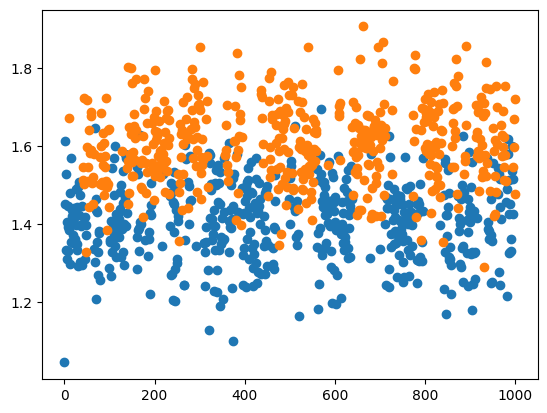

In [7]:
hidden, observed = generateData(1000, mean0=1.4, mean1=1.6) #generate data and plot 

times = np.arange(len(hidden))

for label in np.unique(hidden):
    plt.scatter(times[hidden == label], observed[hidden == label], label=f"Label {label}")

Now we run Gibbs Sampling, which includes a burn-in period of 100 steps.

In [8]:
sampler = GibbsSampler(observed_data=observed)
sampler.initialize()

sampler.sample(numsteps=200)

#swapping labels if needed to match original model, since model can converge to swapped states
accuracy = 1 - sum(abs(sampler.hiddenestimates - hidden)) / len(hidden)
swapped = False
if accuracy < 0.5:
    accuracy = 1 - accuracy
    swapped = True

print("Hidden state accuracy:", accuracy)

Mean estimates: [1.40376366 1.60023189]
Transition prob estimates: [[0.9230575  0.0769425 ]
 [0.07367298 0.92632702]]
Hidden state estimates: [0. 0. 0. ... 1. 1. 1.]
Hidden state accuracy: 0.9150849150849151


Now, we visualize our predictions for the last 100 datapoints.

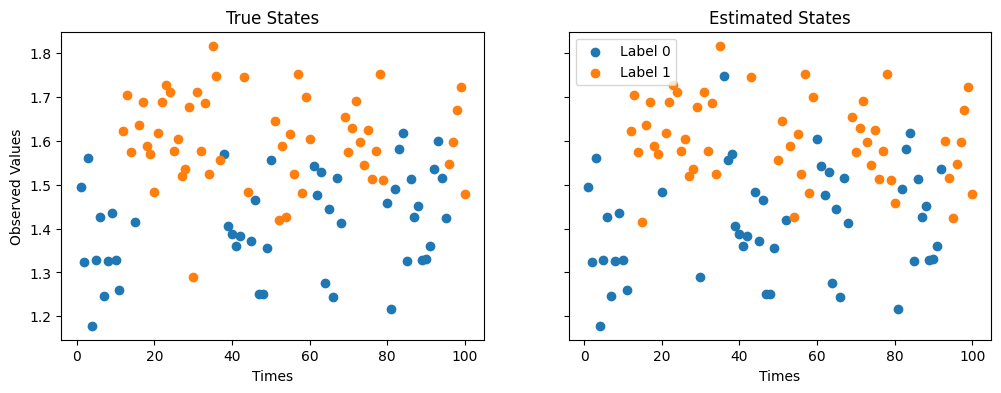

In [12]:
times = np.arange(0,len(hidden))

last_hund_times = times[-100:]
last_hund_observed = observed[-100:]
last_hund_true = hidden[-100:]
last_hund_est = sampler.hiddenestimates[-100:] if not swapped else 1 - sampler.hiddenestimates[-100:]


fig, axs = plt.subplots(1,2,sharey=True, figsize=(12, 4))

for label in np.unique(last_hund_true):
    axs[0].scatter(last_hund_times[last_hund_true == label]-900, last_hund_observed[last_hund_true == label], label=f"State {label}")
    axs[1].scatter(last_hund_times[last_hund_est == label]-900, last_hund_observed[last_hund_est == label], label=f"Label {label}")

axs[0].set_title("True States")
axs[0].set_xlabel("Times")
axs[0].set_ylabel("Observed Values")

axs[1].set_title("Estimated States")
axs[1].set_xlabel("Times")

plt.legend()
plt.show()

This is quite remarkable! Look at the original data for the last 100 data points.

Text(0, 0.5, 'Observed Values')

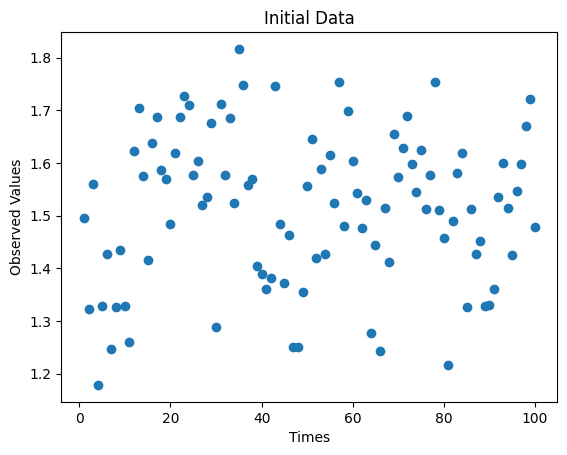

In [13]:
times = np.arange(0,len(hidden))

last_hund_times = times[-100:]
last_hund_observed = observed[-100:]
last_hund_true = hidden[-100:]
last_hund_est = sampler.hiddenestimates[-100:]

plt.scatter(last_hund_times-900,last_hund_observed)

plt.title("Initial Data")
plt.xlabel("Times")
plt.ylabel("Observed Values")





The model was able to take this data and actually learn the true means as well as the transition probabilities.

# Extensions

This is an extremely flexible model, and we can add a lot of complexity to make it more powerful. First of all, we can introduce autoregressive components, which means that $z_t$ will depend on previous observed values as well. This will make the model more flexible to realistic data.

Further, our model only has implementation capabilities for $k=2$ states. Generalizing the model would again make the model suited to a wider range of data sets.

Finally, we considered a common variance across states. This is quite a strong assumption. In the world of stocks, it may be that one state demonstrates higher volatility than another state. Incorporating differing varainces, and posterior estimations for those parameters would be important.